# **Sentiment Analysis**

Sentiment analysis is the process of using **natural language processing (NLP)** and **machine learning** to identify and **extract subjective information** from text, determining whether the emotional tone is positive, negative, or neutral.  
This automated technique helps businesses understand public opinion, monitor brand reputation, and gain deeper insights from large volumes of customer feedback, reviews, and social media comments.

* using BERT + training + logistic regression
* Using TFIDF + training + Naive Bayes
* Using Sentence Embedding + DL approach

## **Using Logistic Regression**

In [1]:
# importing libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

In [ ]:
# reading the dataset

DATASET_ENCODING = "ISO-8859-1"
COLUMNS = ['target', 'id', 'date', 'flag', 'user', 'text']
file_path = "./data/tweet_sentiment_alaysis.csv"

df = pd.read_csv(file_path, encoding=DATASET_ENCODING, names=COLUMNS)

In [6]:
print(f"Shape of the dataset: {df.shape}")
print(f"Columns: {df.columns}")
print("=="*50)
df.head(5)

Shape of the dataset: (1600000, 6)
Columns: Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
# unique values of target
df['target'].unique()

array([0, 4])

0 - negative  
4 - positive

In [8]:
# replacing the value 4 with 1 (for accurate loss calculation)
df['target'] = df['target'].map({4: 1, 0: 0, 1:1})

# selecting columns
df = df[['target', 'text']]

# taking a smaller sample
SAMPLE_SIZE = 50000
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

In [9]:
# observing the balancing of the dataset

df_sample['target'].value_counts()

,count
target,
1,25014
0,24986


* The dataset is balanced.

In [10]:
x = df_sample['text'].tolist()
y = df_sample['target'].values

Now we are using a Pretrained BERT for this sentiment analysis task.  
We will use the output corresponding to **CLS** token, which is often used as the aggregated sentence representation

In [11]:
# -----Initializing BERT model and Tokenizer------

MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

In [12]:
# ----updating the device (according to availabilit)----

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Using: {device}")

Using: cuda


In [13]:
# ----Extracting BERT Embeddings----

def get_bert_features(texts, batch_size=32, max_len=128):
    features = []
    # Process in batches to handle large data and manage memory
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting Features"):
        batch_texts = texts[i:i + batch_size]

        # Tokenization and Preprocessing (handled by the tokenizer)
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors='pt'
        ).to(device)

        # BERT Feature Extraction
        with torch.no_grad():
            output = model(**encoded_input)

        # The first element of the 'last_hidden_state' is the [CLS] token vector
        # This vector represents the entire sequence's context
        cls_embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(cls_embeddings)

    # Concatenate all batch features into a single NumPy array
    return np.concatenate(features, axis=0)

In [14]:
# getting the features for each sentence
X_features = get_bert_features(x)

print(f"\nShape of BERT Features (X_features): {X_features.shape}")
print(f"Shape of Labels (y): {y.shape}")

Extracting Features: 100%|██████████| 1563/1563 [02:22<00:00, 10.96it/s]

Shape of BERT Features (X_features): (50000, 768)
Shape of Labels (y): (50000,)


In [15]:
# --- Split Data ---
X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42
)

print(f"Train Features Shape: {X_train_feat.shape}")
print(f"Test Features Shape: {X_test_feat.shape}")

Train Features Shape: (40000, 768)
Test Features Shape: (10000, 768)


In [16]:
# Training a Logistic Regression model

print("Training Logistic Regression Classifier...")
log_reg = LogisticRegression(max_iter=500, n_jobs=-1)
log_reg.fit(X_train_feat, y_train)

Training Logistic Regression Classifier...


LogisticRegression(max_iter=500, n_jobs=-1)

In [17]:
# --- Make Predictions and Evaluate ---
y_pred = log_reg.predict(X_test_feat)

# --- Evaluation ---
print("--- Evaluation Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

--- Evaluation Results ---
Accuracy: 0.7840

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.79      0.78      0.78      4977
Positive (1)       0.78      0.79      0.79      5023

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



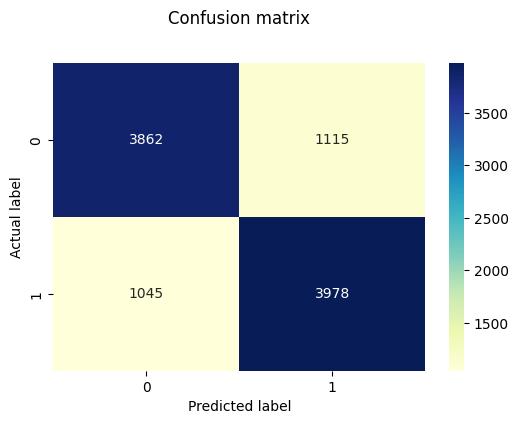

In [18]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cnf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## **Using Naive Bayes**

Steps:
* Clean & Preprocess text
* Vecotrize Text (BOW/TF-IDF)
* Split data
* Train model
* Evaluate model

In [19]:
# importing libraries

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

import nltk
from nltk.corpus import stopwords

In [20]:
# downloading the nltk resource

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# --- Load the Dataset ---

COLUMNS = ['target', 'id', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
DATASET_PATH = './data/tweet_sentiment_alaysis.csv'

df = pd.read_csv(DATASET_PATH, encoding=DATASET_ENCODING, names=COLUMNS)

In [22]:
print(f"Shape of the dataset: {df.shape}")
print(f"Columns: {df.columns}")
print("=="*50)
df.head(5)

Shape of the dataset: (1600000, 6)
Columns: Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [23]:
# --- Select relevant columns and sample ---
df = df[['target', 'text']]
df['target'] = df['target'].replace(4, 1)

# taking sample of the dataset
SAMPLE_SIZE = 50000
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

X = df_sample['text']
y = df_sample['target']

In [24]:
# checking the data imbalance

df_sample['target'].value_counts()

,count
target,
1,25014
0,24986


* Dataset is balanced

In [25]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
print(f"Train Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")

Train Shape: (40000,)
Test Shape: (10000,)


In [27]:
# ----Text Preprocessing----

STOP_WORDS = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (#tag)
    text = re.sub(r'#\w+', '', text)

    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove single characters
    text = re.sub(r'\b\w\b', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Simple stop word removal (optional but common for Naive Bayes)
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])

    return text

In [28]:
# Apply the preprocessing to the training and testing sets

X_train_clean = X_train.apply(preprocess_text)
X_test_clean = X_test.apply(preprocess_text)

In [33]:
# observing a sample

i = 237
print(f"Original Tweet: {X_train.iloc[i]}")
print(f"Cleaned Tweet:  {X_train_clean.iloc[i]}")

Original Tweet: @trixie360 @PlanetXbox360 @FragDolls @majornelson Great press conf!  Some nice &amp; unexpected announcements!  
Cleaned Tweet:  great press conf nice amp unexpected announcements


In [35]:
# ----Feature Extraction using TF-IDF----

vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2)) # considers both 1-gram & 2-gram

X_train_vec = vectorizer.fit_transform(X_train_clean)
X_test_vec = vectorizer.transform(X_test_clean)

In [36]:
print(f"Training data shape after TF-IDF: {X_train_vec.shape}")
print(f"Test data shape after TF-IDF: {X_test_vec.shape}")

Training data shape after TF-IDF: (40000, 25000)
Test data shape after TF-IDF: (10000, 25000)


In [41]:
# --- Initialize and Train Multinomial Naive Bayes ---

nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

MultinomialNB()

In [42]:
# --- Make Predictions ---
y_pred = nb_model.predict(X_test_vec)

# --- Evaluation ---
print("\n--- Evaluation Results (Naive Bayes) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))


--- Evaluation Results (Naive Bayes) ---
Accuracy: 0.7441

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.73      0.76      0.75      4977
Positive (1)       0.76      0.72      0.74      5023

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



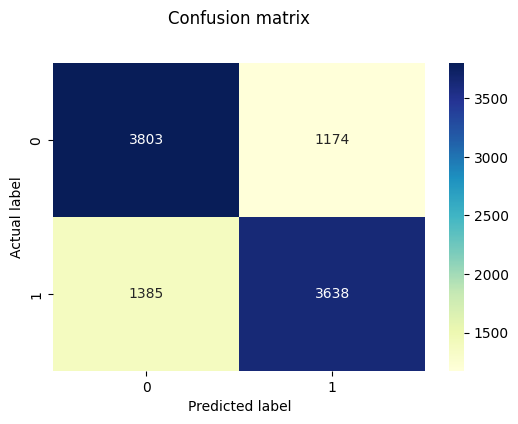

In [44]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cnf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cnf, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## **Using SBERT + LSTM**

In [46]:
# --loading libraries--

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sentence_transformers import SentenceTransformer

import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
# ----Loading data----

COLUMNS = ['target', 'id', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
DATASET_PATH = './data/tweet_sentiment_alaysis.csv'

df = pd.read_csv(DATASET_PATH, encoding=DATASET_ENCODING, names=COLUMNS)

In [48]:
print(f"Shape of the dataset: {df.shape}")
print(f"Columns: {df.columns}")
print("=="*50)
df.head(5)

Shape of the dataset: (1600000, 6)
Columns: Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [49]:
df = df[['target', 'text']]
df['target'] = df['target'].replace(4, 1)

SAMPLE_SIZE = 50000
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

X = df_sample['text']
y = df_sample['target']

In [50]:
# observing the data imbalancing

df_sample['target'].value_counts()

,count
target,
1,25014
0,24986


* Data is balanced

In [51]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [52]:
# ----Preprocessing data----

def preprocess_text_sbert(text):

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [53]:
# Apply the preprocessing

X_train_clean = X_train.apply(preprocess_text_sbert)
X_test_clean = X_test.apply(preprocess_text_sbert)

In [54]:
# observing a sample

i = 99
print(f"Original text: {X_train[i]}")
print(f"Cleaned text: {X_train_clean[i]}")

Original text: @dbferguson I'm using an Asus. Forget which one at the moment since I don't have it near me.But my complaints are similar to yours. 
Cleaned text: i'm using an asus. forget which one at the moment since i don't have it near me.but my complaints are similar to yours.


In [56]:
# --- Load SBERT Model ---
SBERT_MODEL = 'all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(SBERT_MODEL)

print(f"\nGenerating embeddings using {SBERT_MODEL}...")


Generating embeddings using all-MiniLM-L6-v2...


In [57]:
# Generate sentence embeddings

BATCH_SIZE = 128
X_train_embeddings = embedding_model.encode(
    X_train_clean.tolist(),
    show_progress_bar=True,
    batch_size=BATCH_SIZE,
    convert_to_numpy=True
)
X_test_embeddings = embedding_model.encode(
    X_test_clean.tolist(),
    show_progress_bar=True,
    batch_size=BATCH_SIZE,
    convert_to_numpy=True
)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [58]:
EMBEDDING_DIM = X_train_embeddings.shape[1]

print(f"Embedding dimension: {EMBEDDING_DIM}")
print(f"Training embeddings shape: {X_train_embeddings.shape}")

Embedding dimension: 384
Training embeddings shape: (40000, 384)


In [59]:
# Reshape for Keras GRU: (samples, timesteps, features)
# SBERT embeddings are single-vector representations, so timesteps = 1

X_train_final = np.expand_dims(X_train_embeddings, axis=1)
X_test_final = np.expand_dims(X_test_embeddings, axis=1)

print(f"Final Keras input shape (Training): {X_train_final.shape}")

Final Keras input shape (Training): (40000, 1, 384)


In [60]:
# ----Defining a GRU model----

def build_gru_model(input_shape, gru_units=256, dropout_rate=0.3):
    model = Sequential([
        # GRU layer: input_shape is (timesteps=1, features=384)
        GRU(gru_units,
            input_shape=input_shape,
            return_sequences=False,
            name='gru_layer'),

        Dropout(dropout_rate, name='dropout_layer'),

        # Output Dense layer for binary classification (sigmoid activation)
        Dense(1, activation='sigmoid', name='output_layer')
    ], name="SBERT_GRU_Classifier_Keras")

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [61]:
# Model Hyperparameters
GRU_UNITS = 256
DROPOUT_RATE = 0.3
EPOCHS = 5
BATCH_SIZE_FIT = 64

# Build and print model summary
model = build_gru_model(
    input_shape=(X_train_final.shape[1], X_train_final.shape[2]),
    gru_units=GRU_UNITS,
    dropout_rate=DROPOUT_RATE
)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "SBERT_GRU_Classifier_Keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_layer (GRU)                 │ (None, 256)            │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,313 (1.88 MB)

 Trainable params: 493,313 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
print("\n--- Training the SBERT + GRU Model (Keras) ---")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)


--- Training the SBERT + GRU Model (Keras) ---


In [63]:
history = model.fit(
    X_train_final,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE_FIT,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7397 - loss: 0.5412 - val_accuracy: 0.7673 - val_loss: 0.4836
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7724 - loss: 0.4765 - val_accuracy: 0.7717 - val_loss: 0.4824
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7767 - loss: 0.4726 - val_accuracy: 0.7697 - val_loss: 0.4787
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7748 - loss: 0.4721 - val_accuracy: 0.7675 - val_loss: 0.4805
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7775 - loss: 0.4664 - val_accuracy: 0.7700 - val_loss: 0.4777


In [64]:
print("\n--- Evaluation on Test Set ---")

# Predict probabilities
y_pred_proba = model.predict(X_test_final)

# Convert probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy and print report
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))


--- Evaluation on Test Set ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.7741

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.78      0.77      0.77      4977
Positive (1)       0.77      0.78      0.78      5023

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



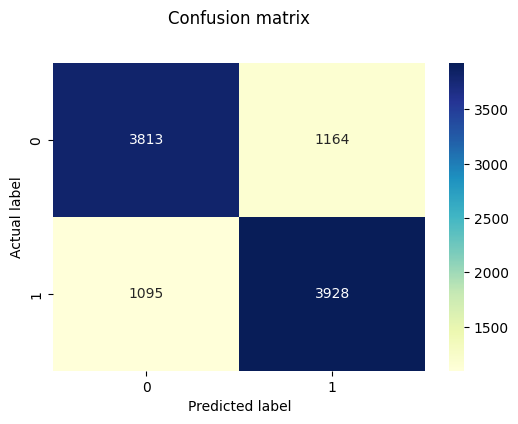

In [65]:
# confusion matrix

cnf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cnf, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()